<a href="https://colab.research.google.com/github/rishuraj27/Coursera_Capstone/blob/master/employee_attrition_rate%20with%20outlier%20treatment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split

In [2]:
train_df = pd.read_csv("/content/Train.csv")
test_df = pd.read_csv("/content/Test.csv")

In [ ]:
train_df.head()

In [4]:
numerical= ['Age',  'Time_of_service', 'Time_since_promotion', 'growth_rate',  
        'VAR1', 'VAR2', 'VAR3', 'VAR4', 'VAR5', 'VAR6','VAR7'] 
dep = ['Attrition_rate']
integer =['Time_since_promotion', 'growth_rate','VAR1', 'VAR5', 'VAR6','VAR7']
categorical = ['Employee_ID', 'Gender','Education_Level','Relationship_Status', 
              'Hometown','Unit', 'Decision_skill_possess','Travel_Rate',
       'Post_Level', 'Pay_Scale','Work_Life_balance','Compensation_and_Benefits']

In [ ]:
train_df.info()

## Missing treatment

In [ ]:
train_df[numerical].isnull().sum()

In [ ]:
train_df[categorical].isnull().sum()

In [10]:
#Train numerical data imputation
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5,weights='distance')
train_df[numerical] = pd.DataFrame(imputer.fit_transform(train_df[numerical]),columns=numerical)

In [11]:
#Test numerical data imputation
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5,weights='distance')
test_df[numerical] = pd.DataFrame(imputer.fit_transform(test_df[numerical]),columns=numerical)

In [12]:
for var in integer:
    train_df[var] = np.round(train_df[var])
    test_df[var] = np.round(test_df[var])

In [13]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
train_df[categorical]= imp.fit_transform(train_df[categorical])
test_df[categorical]= imp.fit_transform(test_df[categorical])

In [14]:
train_df.isnull().sum()

Employee_ID                  0
Gender                       0
Age                          0
Education_Level              0
Relationship_Status          0
Hometown                     0
Unit                         0
Decision_skill_possess       0
Time_of_service              0
Time_since_promotion         0
growth_rate                  0
Travel_Rate                  0
Post_Level                   0
Pay_Scale                    0
Compensation_and_Benefits    0
Work_Life_balance            0
VAR1                         0
VAR2                         0
VAR3                         0
VAR4                         0
VAR5                         0
VAR6                         0
VAR7                         0
Attrition_rate               0
dtype: int64

In [15]:
test_df.isnull().sum()

Employee_ID                  0
Gender                       0
Age                          0
Education_Level              0
Relationship_Status          0
Hometown                     0
Unit                         0
Decision_skill_possess       0
Time_of_service              0
Time_since_promotion         0
growth_rate                  0
Travel_Rate                  0
Post_Level                   0
Pay_Scale                    0
Compensation_and_Benefits    0
Work_Life_balance            0
VAR1                         0
VAR2                         0
VAR3                         0
VAR4                         0
VAR5                         0
VAR6                         0
VAR7                         0
dtype: int64

## Encoding categorical variable

In [16]:
categorical.remove("Employee_ID")
train_df= pd.get_dummies(train_df,columns= categorical)
test_df= pd.get_dummies(test_df,columns= categorical)

In [17]:
train_df.shape

(7000, 71)

## Outlier Treatment

In [19]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors


In [21]:
data_out = train_df[numerical].copy(deep=True)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_out = scaler.fit_transform(data_out)

In [22]:
len(numerical)

11

In [23]:
neigh = NearestNeighbors(n_neighbors=len(numerical)-1)
nbrs = neigh.fit(data_out)
distances, indices =nbrs.kneighbors(data_out)

In [24]:
distances = distances[:,len(numerical)-2]
distances = np.sort(distances,axis=0)

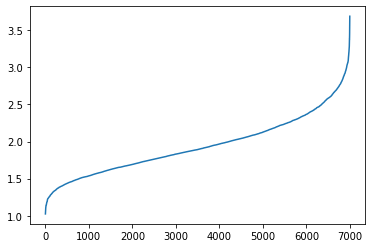

In [25]:
plt.plot(distances)

In [28]:
outlier_detection = DBSCAN(eps=2.8, min_samples= 12)
clustering = outlier_detection.fit(data_out)
unique_elements, counts_elements = np.unique(clustering.labels_,return_counts=True)
np.asarray((unique_elements,counts_elements))

array([[  -1,    0],
       [  16, 6984]])

In [29]:
outlier_indicies= []
for i in range(len(clustering.labels_)):
  if clustering.labels_[i] == -1:
    outlier_indicies.append(i)

In [31]:
data_out_ind = set(train_df.index)
inliers_indicies = data_out_ind - set(outlier_indicies)

In [34]:
train_df= train_df.iloc[list(inliers_indicies),:]

## dependent and independent variable

In [62]:
emp_id=train_df[["Employee_ID"]]
X=train_df.drop(["Employee_ID","Attrition_rate"],axis=1)
y=train_df[["Attrition_rate"]]

In [55]:
dt = DecisionTreeRegressor(max_depth=10,min_samples_leaf=0.15,random_state=3)

In [56]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=3)

In [57]:
dt.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=0.15, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=3, splitter='best')

In [58]:
y_pred= dt.predict(X_test)

In [59]:
mse_dt=MSE(y_test,y_pred)

In [60]:
rmse_dt = np.sqrt(mse_dt)
rmse_dt

0.1829035660339349

In [61]:
score = 100* max(0, 1-rmse_dt )
score

81.70964339660651

In [63]:
test_df_final = test_df.drop("Employee_ID",axis =1)
y_test_pred = dt.predict(test_df_final)

In [64]:
y_test_pred

array([0.1981699 , 0.1981699 , 0.1765125 , ..., 0.1981699 , 0.18007961,
       0.20311042])

In [66]:
dd = {"Employee_ID":test_df["Employee_ID"], "Attrition_rate":y_test_pred}
result = pd.DataFrame(dd,index= None)

In [67]:
result.head()

,Employee_ID,Attrition_rate
0,EID_22713,0.198170
1,EID_9658,0.198170
2,EID_22203,0.176512
3,EID_7652,0.186339
4,EID_6516,0.186339


In [68]:
result.to_csv("/content/result.csv")

In [69]:
score = 100* max(0, 1-rmse_dt )
score

81.70964339660651